In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
model_name='details-100k'

In [5]:
path=Path('data')

In [7]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')

In [8]:
df_train = df_raw[df_raw['lang'] == 'en']
df_test = df_raw_test[df_raw_test['lang'] == 'en']

In [9]:
df_all = df_train[['details']].append(df_test[['details']])

In [10]:
# max_vocab = 60k by default - seting it to lower value to make training faster
# txt_proc = [TokenizeProcessor(), NumericalizeProcessor(vocab=None, max_vocab=100000)]
# data_lm = (TextList.from_df(df_all, path=path, processor=txt_proc)
# data_lm = (TextList.from_df(df_all, path=path)
#            .split_by_rand_pct(0.05)
#            .label_for_lm()
#            .databunch(bs=192)
#           )
# print(f'Vocabulary size {len(data_lm.vocab.itos)}')

Vocabulary size 100004


In [11]:
data_lm.save(f'data-lm-{model_name}.pkl')

In [6]:
bs = 64 # 128 = 12502MiB (60k)

In [7]:
data_lm = load_data(path, f'data-lm-{model_name}.pkl', bs=bs)

### LM Training

In [8]:
learn_nlp = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


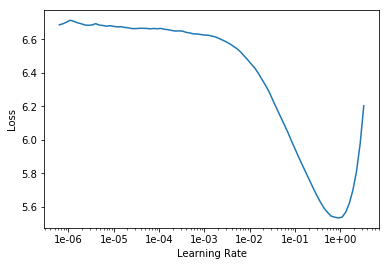

In [15]:
learn_nlp.lr_find(); learn_nlp.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.789320,1.548031,0.716199,1:10:21
1,1.812427,1.532546,0.719662,1:10:28
2,1.762631,1.513882,0.723584,1:10:33
3,1.750796,1.477844,0.729683,1:10:36
4,1.661003,1.435887,0.736993,1:10:46
5,1.697405,1.393503,0.744806,1:10:52
6,1.595571,1.366661,0.749521,1:11:02
7,1.597845,1.360018,0.750978,1:11:00


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



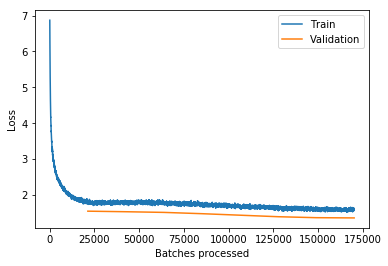

In [9]:
learn_nlp.fit_one_cycle(8, 1e-2, moms=(0.8,0.7)); learn_nlp.recorder.plot_losses()

In [10]:
learn_nlp.save(f'lm-{model_name}-1')

In [9]:
learn_nlp.load(f'lm-{model_name}-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1540520 items)
x: LMTextList
xxbos opstechit - xxup hou2 xxmaj project opstechit xxmaj manual opstechit xximpacthigh xxmaj equipment xxmaj request ( xxmaj new / xxmaj loaner ) xxup hou2 - xxup fc ( xxmaj houston , xxup tx ) xxmaj sort - xxup ar xxup houston xxup us xxup hou2 xxup tx xxmaj client xxmaj devices xxup hou2 - xxmaj singles problem solve request xxmaj building i d : xxup hou2 xxmaj workflow name : opstechit_devices_and_equipment_other xxmaj description : xxmaj problem xxmaj solve xxmaj stations on xxmaj line 3 , 4 , & 5 as well as xxmaj audit at xxmaj slam 6 in xxmaj pack xxmaj singles need to be fully setup as problem solve & xxmaj pack xxmaj stations . xxmaj each location must be fully functional for problem solve to pack out items . xxmaj in addition to work tables , equipment needed : xxmaj tape xxmaj dispensers , xxmaj dunnage xxmaj machines , xxmaj full xxmaj box xxmaj suites , xxmaj spoo xxmaj machines , p - xxm

In [11]:
learn_nlp.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


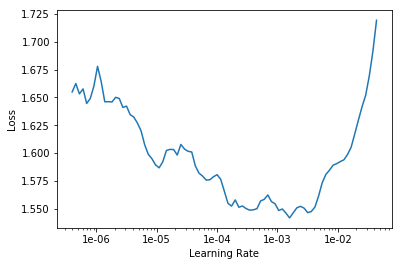

In [12]:
learn_nlp.lr_find(end_lr=1e-1); learn_nlp.recorder.plot()

In [13]:
learn_nlp.fit_one_cycle(5, 5e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.404310,1.234453,0.769075,1:17:09
1,1.289922,1.136537,0.786637,1:17:19
2,1.219655,1.095705,0.793951,1:17:15
3,1.169227,1.080500,0.796690,1:17:23
4,1.160916,1.078010,0.797155,1:17:45


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#0.801500 was on 60k

In [14]:
learn_nlp.save(f'lm-{model_name}-tuned')

In [15]:
learn_nlp.save_encoder(f'{model_name}-tuned-enc')

### Test

In [16]:
TEXT = "printer"
N_WORDS = 30
N_SENTENCES = 10
print("\n\n".join(learn_nlp.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

printer not working at IB receive station # 5 xxbos The following 2 alert(s ) have occurred on camera Interior . Inbound . Receive .

printer not working at lane 1 Printer not working xxbos Hello , Station stations on line 10 are not connecting to the internet . Can someone please

printer not working properly in OB Dock xxbos Hostname : xxhost Check : ping Details : PING CRITICAL - Packet loss = 100

printer not working xxbos Issue Description ( Break - fix / Maintenance ) : Locker is out of sync . Taking locker offline .

printer is not working at pack station 2 - 6 . Printer is not printing p - slips . Please assist . xxbos NARF Audit picked up

printer at the east side dock is not printing . xxbos This ticket is to track the time spent in the returns start up to help fix the issues they

printer not printing . xxbos Perform the daily status check of the MDF room . Follow SOP : xxpolicy xxbos Building i d : LAS6

printer is not working . The printer is printing only half of it 's la

60k samples

```
printer on SLAM station simultaneously is not clear , please assist . ! xxbos Building i d : MCO5 Workflow name : opstechit_password Description :

printer will not print shipping labels xxbos Workflow name : Labels Installation - Zebra 600 m warehouseid : CMH1 Printer Model : Zebra

printer not working at station 1407 xxbos Perform the daily status check of the MDF room . Follow SOP : xxpolicy xxbos Please walk the

printer on slam 3 is not working properly . It is not printing xxbos Each day please check all defective bin locations for scanners that have been placed in

printer not working xxbos Setting up RF scanners . Please deploy scanners and batteries to the IT cage . xxbos Hi , Please provide access

printer working on slam 7 station 7 perform a Manual Slam printer located at BOD . Please check ink . xxbos Dock is not printing in

printer not working at printer in learning - location xxbos Chat Dialog- for contacting Centralized opstechit , how may i assist you ? Do you have a

printer is not working . xxbos The following 1 alert(s ) have occurred on camera Interior . East Side . Ground . Receive .

printer 1 - 7 not printing xxbos The following 1 alert(s ) have occurred on camera Interior . East Pick Mod.1st Floor . P1

printer on mobile cart is not working . Printer not working , Front of printer is working . xxbos Laptop at PS Cart # 4 has
```